In [1]:
import matplotlib.pyplot as plt
import matplotlib
import os
from fits_reader import shelf,fits_reader
import importlib
import glob
import spec_reader
import gc
import math
import sys
import numpy as np
import csv
from scipy import interpolate
import csv
importlib.reload(fits_reader)
importlib.reload(spec_reader)
importlib.reload(spec_reader.irradiance)
importlib.reload(spec_reader.angle_function)
importlib.reload(shelf)


<module 'fits_reader.shelf' from '/home/ciber2/python/calibration/fits_reader/shelf.py'>


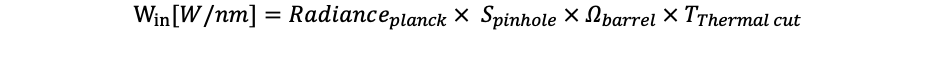





透過率を求める  
1.NIR Detector 重み付け積分
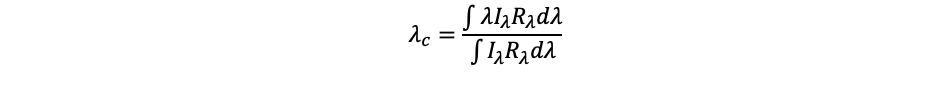

In [2]:
"""
make_reduction_shelf
"""

arms = ["armS","armM","armL"]
home_directory = os.environ['HOME']
season_name = "/WSMR2021May/reduction/2021-06-23"
experiment_name = "/abs_calib/NIR/"
experiment_directory = home_directory + season_name + experiment_name
reduction_shelf = shelf.make_reduction_shelf(experiment_directory)
reduction_shelf.get_all_books()
# cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)

['①refOD1_&_②Thermal_cut_L__x_③Blank_@500mm',
 '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm',
 '①refOD1×②Thermal_cut_M__x_③Blank',
 '①absOD1_x_②absOD2_x_③Thermal_cut__S',
 'Sphere_loading_@_250_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 'Sphere_loading_@_500_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 '①refOD1_&_②Thermal_cut_L__x_③Blank_@250mm',
 '①refOD1×②Thermal_cut_L__x_③Blank',
 'Sphere_loading_@_0_mm:_①Thermal_cut_L_x_②_Blank_x_③Blank',
 '①absOD1_×_②Thermal_cut_S__x_③Blank']

Text(0, 0.5, 'BB radiance [W/m^2/sr/nm]')

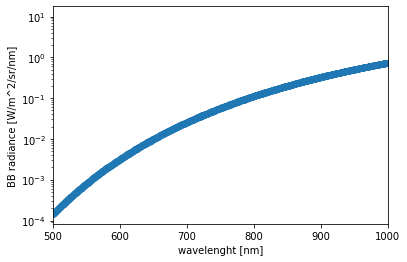

In [3]:
"""
black body
"""

waves = np.arange(500,10000,)
irr = spec_reader.irradiance.get_BB_from_planck(waves,1200)
plt.scatter(waves,irr)
plt.xlim(500,1000)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("BB radiance [W/m^2/sr/nm]")


Blank doesn't match
Blank doesn't match
Blank_@0mm doesn't match


Text(0, 0.5, 'transparent')

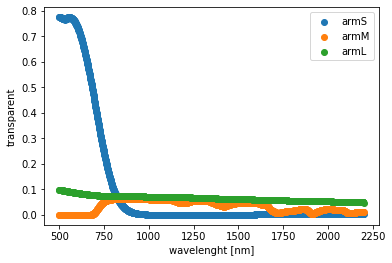

In [4]:
experiment_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'
waves,total_transparent = spec_reader.irradiance.get_transparent_from_filter_conbination(experiment_name)
plt.scatter(waves,total_transparent,label="armS")
experiment_name = '①refOD1×②Thermal_cut_M__x_③Blank'
waves,total_transparent = spec_reader.irradiance.get_transparent_from_filter_conbination(experiment_name)
plt.scatter(waves,total_transparent,label="armM")
experiment_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'
waves,total_transparent = spec_reader.irradiance.get_transparent_from_filter_conbination(experiment_name)
plt.scatter(waves,total_transparent,label="armL")
# plt.xlim(800,1600)
plt.legend()
plt.xlabel("wavelenght [nm]")
plt.ylabel("transparent")


Blank doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

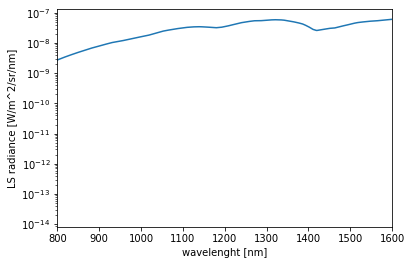

In [5]:
experiment_name = '①refOD1×②Thermal_cut_M__x_③Blank'
waves,ls_irradiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)
plt.plot(waves,ls_irradiance)
plt.xlim(800,1600)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

Blank doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

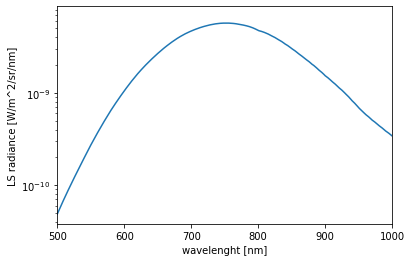

In [6]:
experiment_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'
waves,ls_irradiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)
plt.plot(waves,ls_irradiance)
plt.xlim(500,1000)
# plt.ylim(10,10**-)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

Blank_@0mm doesn't match


Text(0, 0.5, 'LS radiance [W/m^2/sr/nm]')

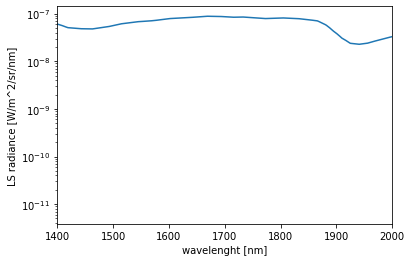

In [7]:
experiment_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'
waves,ls_irradiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)
plt.plot(waves,ls_irradiance)
plt.xlim(1400,2000)
# plt.ylim(10,10**-)
plt.yscale("log")
plt.xlabel("wavelenght [nm]")
plt.ylabel("LS radiance [W/m^2/sr/nm]")

1225.990434684987


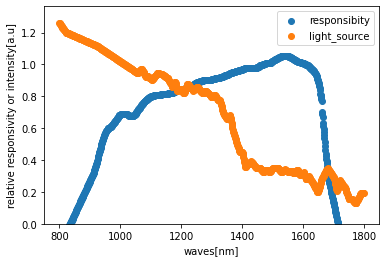

In [8]:
def read_data(file):
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        rawData = [row for row in reader]
        return np.array(rawData,dtype=np.float16).T
    
res_file = "./lib/LS_transmittance/Response_curve.csv"
light_file = "./lib/LS_transmittance/Light_radiance.csv"
res_data = read_data(res_file)
light_data = read_data(light_file)

waves= np.arange(800,1800)
res_itp = interpolate.interp1d(res_data[0],res_data[1],fill_value="extrapolate")(waves)
light_itp = interpolate.interp1d(light_data[0]*1000,light_data[1],fill_value="extrapolate")(waves)

fig,ax = plt.subplots()
ax.scatter(waves,res_itp,label="responsibity")
ax.scatter(waves,light_itp,label="light_source")
ax.set_ylim(0)
ax.set_xlabel("waves[nm]")
ax.set_ylabel("relative responsivity or intensity[a.u]")
ax.legend()
denominator = 0
fraction = 0

"""
integral
"""
for i in range(len(res_itp)):
    if res_itp[i] > 0:
        fraction = fraction + waves[i]*res_itp[i]*light_itp[i]
        denominator = denominator + res_itp[i]*light_itp[i]
print(fraction/denominator)


(0.0, 1.0)

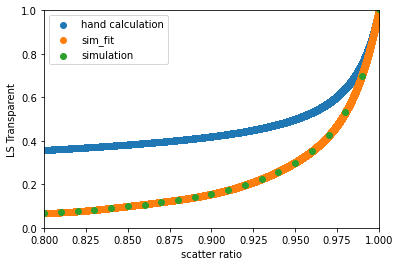

In [9]:
import pandas as pd

df = pd.read_csv('./lib/LS_transmittance/LS_sim.csv')

scatter_rate_sim = df["Scatter_rate_sim"]
transparent_sim = df["Transparent_sim"]
x_hand = df["Scatter_rate_hand"]
y_hand = df["Transparent_hand"]
trans_4_fit=np.polyfit(np.array(scatter_rate_sim)[:26], np.array(transparent_sim)[:26],8)
y_4_fit = np.poly1d(trans_4_fit)(x_hand) #1次

fig,ax = plt.subplots()
ax.scatter(x_hand,y_hand,label="hand calculation")
ax.scatter(x_hand,y_4_fit,label="sim_fit")
ax.scatter(scatter_rate_sim,transparent_sim,label="simulation")
ax.set_xlabel("scatter ratio")
ax.set_ylabel("LS Transparent")
ax.legend()
ax.set_xlim(0.8,1)
ax.set_ylim(0,1)



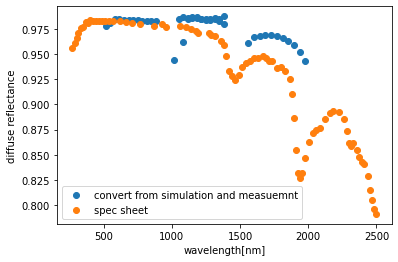

In [10]:
from scipy.optimize import curve_fit

def get_scattering_fn():
    excel_name = "./lib/Loading/simulation_xlsx/Loading_without_direct.xlsx"
    df = pd.read_excel(excel_name,sheet_name='vs_scattering',engine='openpyxl')

    """
    散乱率決定表
    """
    x = df["ratio"]
    y = df["Roading"]
    co = np.polyfit(x,y,8)
    fn = np.poly1d(co)
    # x_sc = np.arange(0.9,1.01,0.01)
    return fn


def func_1_div_e(x, a, b, c):
    return a / np.exp(-b * x) + c
    
def get_scattering_rev_fn():
    """
    散乱率決定表 reverse
    """
    excel_name = "./lib/Loading/simulation_xlsx/Loading_without_direct.xlsx"
    df = pd.read_excel(excel_name,sheet_name='vs_scattering',engine='openpyxl')
    x = df["ratio"][1:][:5]
    y = df["Roading"][1:][:5]
    popt, pcov = curve_fit(func_1_div_e, y, x,p0=(-1,-10,1))
    
    """
    plt.scatter(y,x,)
    plt.xlabel("loading")
    plt.ylabel("scattering")
#     plt.savefig("./csv/loaidng_vs_scattering")
#     plt.close()
    """
    return popt



def get_loading():
    noda_excels = "./lib/Loading/noda_calc/loading_LVF_*"

    files = glob.glob(noda_excels)
    # print(sfiles)
    def get_w_loading(file):
        df = pd.read_csv(file)
        x = df["# wavelength(nm)"]
        y = df[" loading"]
        return x,y
    x_all = []
    y_all = []
    for f in files:
        x,y, = get_w_loading(f)
        x_all.append(x.values)
        y_all.append(y.values)
    x_all_flat = np.array([item for l in x_all for item in l])-1
    y_all_flat = np.array([item for l in y_all for item in l])-1
    return x_all_flat,y_all_flat

def get_loading_fit():
    x_all_flat,y_all_flat = get_loading()
    co = np.polyfit(x_all_flat,y_all_flat,7)
    fn = np.poly1d(co)
    return fn

popt =get_scattering_rev_fn()
loading_x,loading_y = get_loading()

x_array = np.arange(600,2000,step=10)
scattering_convert_from_sim_and_measurement = func_1_div_e(loading_y, *popt)
wave_for_scattering_convert_from_sim_and_measurement = loading_x
plt.scatter(loading_x,func_1_div_e(loading_y, *popt),label="convert from simulation and measuemnt")


spectraflect_file = "./lib/LS_transmittance/spectraflect.csv"
df = pd.read_csv(spectraflect_file)
spectraflect_x = df.iloc[:,0]
spectraflect_y = df.iloc[:,1]
plt.scatter(spectraflect_x,spectraflect_y,label = "spec sheet")
plt.legend()
plt.xlabel("wavelength[nm]")
plt.ylabel("diffuse reflectance")
plt.savefig("./csv/compare_scattering_spec_to_sim")
plt.show()


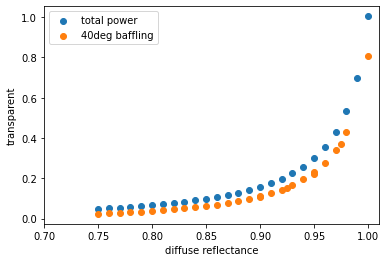

In [11]:
excel_name = "./lib/LS_transmittance/LS_Transparent_simulation.xlsx"
df = pd.read_excel(excel_name,sheet_name='Sheet1',engine='openpyxl')

x_total = df['Scattering_total']
y_total = df['Transparent_total']

x_40deg = df['Scattering_40deg'][:29]
y_40deg = df['Transparent_40deg'][:29]

param = np.polyfit(x_40deg, y_40deg,8)
fn = np.poly1d(param)
x_fit = np.arange(0.7,1,step=0.001)


plt.scatter(x_total,y_total,label = "total power")
plt.scatter(x_40deg,y_40deg,label = "40deg baffling")
plt.legend()
plt.xlabel('diffuse reflectance')
plt.ylabel('transparent')
plt.xlim(0.7,1.01)
# plt.savefig('./csv/transparent_from_simulation')
plt.show()

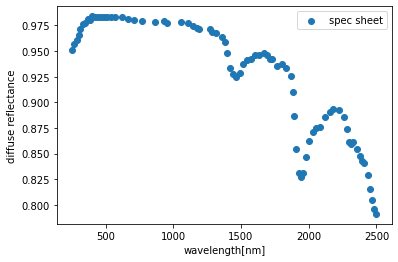

In [12]:
df = pd.read_csv('./lib/LS_transmittance/spectraflect.csv',header=None)
spectralon_wave = df[0]
spectralon_ref = df[1]

fig,ax = plt.subplots()
ax.scatter(spectralon_wave,spectralon_ref,label="spec sheet")
ax.set_xlabel("wavelength[nm]")
ax.set_ylabel("diffuse reflectance")
ax.legend()


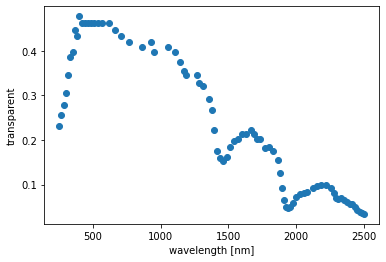

In [13]:
df = pd.read_csv('./lib/LS_transmittance/spectraflect.csv',header=None)
wave_specsheet = df[0]
ref_spectraflect = df[1]
transparent_from_fn_and_specsheet = fn(ref_spectraflect)

plt.scatter(wave_specsheet,transparent_from_fn_and_specsheet)

plt.xlabel('wavelength [nm]')
plt.ylabel('transparent')
plt.savefig('./csv/transparent_from_specsheet_and_simulation')


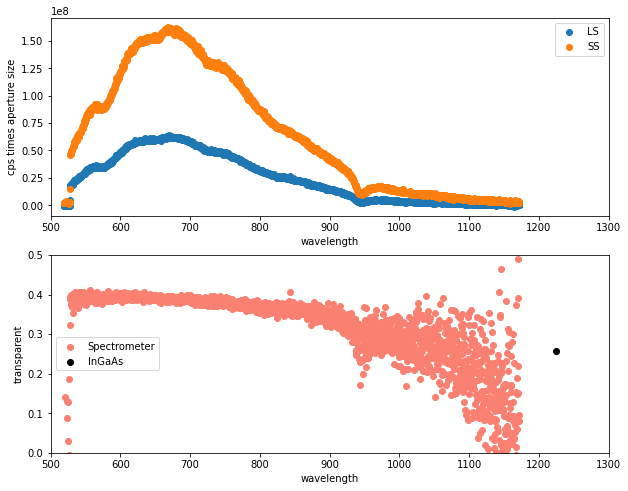

In [14]:
"""
for LS out put
"""
home_directory = os.environ['HOME']
data_folder = home_directory + "/Data/spectrometer/LS_scan/Spectrometer_Readings_01312022"
data_files = sorted(glob.glob(data_folder+"/Light/*"),reverse=True)
str_set = set()
for f in data_files:
    str_set.add(int(f.split('/')[-1].split('_')[0]))
indexes = sorted(str_set)

# print(data_files)
light_data_dict = {}
dark_data_dict = {}
for i in sorted(str_set):
    number_str = str(i)
    one_exp_files = sorted(glob.glob(data_folder+"/Light/" + number_str+ "_*"))
    one_exp_dark_files = sorted(glob.glob(data_folder+"/Dark/" + number_str+ "_*"))
    light_data_dict[i] = one_exp_files
    dark_data_dict[i] = one_exp_dark_files

# print(light_data_dict)
wave,measured_cps_LS = spec_reader.spec_reader.get_cps_2(light_data_dict[110],dark_data_dict[110])

fig,axs = plt.subplots(2,)
fig.set_size_inches(10,8)

ax = axs[0]
measured_cps_times_aperture_LS = measured_cps_LS*((330/2)**2*math.pi)
ax.scatter(wave,measured_cps_times_aperture_LS,label="LS")
    
    
home_directory = os.environ['HOME']
data_folder = home_directory + "/Data/spectrometer/LS_scan/Small_Sphere_Readings_02062022"

light_data_SS = sorted(glob.glob(data_folder+"/Light/*"),reverse=True)
dark_data_SS = sorted(glob.glob(data_folder+"/Dark/*"),reverse=True)

wave,measured_cps_SS =  spec_reader.spec_reader.get_cps_2(light_data_SS,dark_data_SS)
measured_cps_times_aperture_SS = measured_cps_SS*((25.4/2)**2*math.pi) 

ax.scatter(wave,measured_cps_times_aperture_SS,label="SS")
ax.set_xlabel("wavelength")
ax.set_ylabel("cps times aperture size")
ax.set_xlim(500,1300)
ax.legend()

ax2 = axs[1]
transparent = measured_cps_times_aperture_LS/measured_cps_times_aperture_SS
ax2.scatter(wave,transparent,c='salmon',label="Spectrometer")
ax2.scatter(1225,0.258326669,c='black',label="InGaAs")
coe=np.polyfit(wave, transparent, 3)
y = np.poly1d(coe)(wave)
# print(y)
wave_binned = []
ts_binned = []
ts_tmp = []
for i,t in enumerate(transparent):
    ts_tmp.append(t)
    if i%100 == 99:
        wave_binned.append(wave[i-50])
        ts_binned.append(np.average(ts_tmp))
        ts_tmp = []

ts_binned.append(0.258326669)
wave_binned.append(1225)

ts_binned_np = np.array(ts_binned)
wave_binned_np = np.array(wave_binned)
# print(ts_binned)
# print(wave_binned)
# ax2.plot(wave_binned_np,ts_binned_np,c='red',label="100pix average")
# ax2.plot(spectralon_wave,ls_transparent_from_spectralon_ref,c='blue',label="transparent_from_spectralon")
# ax2.scatter(wave,y,c='maroon',label="Spectrometer")
# print(coe)

ax2.legend()
ax2.set_xlabel("wavelength")
ax2.set_ylabel("transparent")
# ax2.set_xlim(500,2000)
ax2.set_xlim(500,1300)
ax2.set_ylim(0,0.5)


home_directory = os.environ['HOME']
data_folder = home_directory + "/Data/spectrometer/LS_scan/Spectrometer_Readings_01312022"
data_files = sorted(glob.glob(data_folder+"/Light/*"),reverse=True)

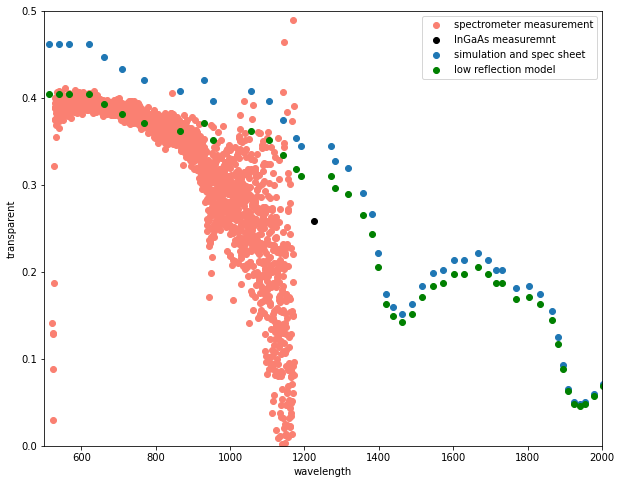

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(10,8)

ax.scatter(wave,transparent,c='salmon',label="spectrometer measurement")
ax.scatter(1225,0.258326669,c='black',label="InGaAs measuremnt")
ax.scatter(wave_specsheet,transparent_from_fn_and_specsheet,label='simulation and spec sheet')
transparent_from_fn_and_specsheet_decrease = fn(ref_spectraflect*0.995)
ax.scatter(wave_specsheet,transparent_from_fn_and_specsheet_decrease,c= 'green',label='low reflection model')
ax.set_xlabel("wavelength")
ax.set_ylabel("transparent")
ax.set_xlim(500,2000)
ax.set_ylim(0,0.5)
ax.legend()

file = "./lib/sphere_transmittance/LS_transparent_calculated_by_simulation.csv"
# print(wave_specsheet,transparent_from_fn_and_specsheet_decrease)
# print(type(wave_specsheet))
# print(type(wave_specsheet.values))
# print(type(transparent_from_fn_and_specsheet_decrease))
save_data = np.array((wave_specsheet.values,transparent_from_fn_and_specsheet_decrease)).T
# print(save_data)
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerow(np.array(("wavelength","transparent"))) #行一括追加
    csv_writer.writerows(save_data) #行一括追加    



In [16]:
experiment_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'
armS_wave,armS_radiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)
experiment_name = '①refOD1×②Thermal_cut_M__x_③Blank'
armM_wave,armM_radiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)
experiment_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'
armL_wave,armL_radiance= spec_reader.irradiance.calc_ls_radiance(experiment_name,1200)

# plt.plot(waves,ls_irradiance)
# plt.xlim(800,1600)
# plt.yscale("log")
# plt.xlabel("wavelenght [nm]")
# plt.ylabel("LS radiance [W/m^2/sr/nm]")
# armM_wave = waves
# armM_radiance = ls_irradiance

Blank doesn't match
Blank doesn't match
Blank_@0mm doesn't match


In [17]:
# waves,ls_irradiance= cf_class.getIrradiance(book_name)
# plt.plot(waves,ls_irradiance)
# plt.xlim(1400,2000)
# # plt.ylim(10,10**-)
# plt.yscale("log")
# plt.xlabel("wavelenght [nm]")
# plt.ylabel("LS radiance [W/m^2/sr/nm]")

In [18]:
# armL_wave = waves
# armL_radiance = ls_irradiance

In [19]:
#WPF_transmittance
wpf = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/WPF/pickup/*.csv'))

#blocker_transmittance
blocker = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/blocker/pickup/*.csv'))

#beam_splitter
bs = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/BS/pickup/*.csv'))

In [20]:
import csv
wpf_trans  = []
wavelength_all = []
for i in range(len(wpf)):
    wavelength = []
    trans = []
    with open(wpf[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            wavelength.append(float(row[0]))
            trans.append(float(row[1])/100)
    wpf_trans.append(np.array(trans))
    wavelength_all.append(wavelength)

blocker_trans  = []
for i in range(len(blocker)):
    trans = []
    with open(blocker[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    blocker_trans.append(np.array(trans))

bs_trans  = []
for i in range(len(bs)):
    trans = []
    with open(bs[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    bs_trans.append(np.array(trans))

In [21]:
arms1 = wpf_trans[0] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)
arms2 = wpf_trans[1] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)
armm1 = wpf_trans[2] * blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14)
armm2 = wpf_trans[3] * blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14)
arml1 = wpf_trans[4] * blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14)
arml2 = wpf_trans[5] * blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14)

In [22]:
arms_wavelength = wavelength_all[0]
armm_wavelength = wavelength_all[2]
arml_wavelength = wavelength_all[4]
print(arms_wavelength[0],armm_wavelength[0],arml_wavelength[0])

420.0 900.0 1353.0


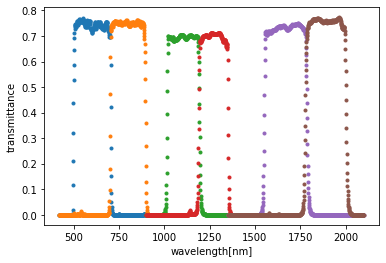

In [23]:
plt.plot(arms_wavelength, arms1, marker='o', lw=0, ms=3)
plt.plot(arms_wavelength, arms2, marker='o', lw=0, ms=3)
plt.plot(armm_wavelength, armm1, marker='o', lw=0, ms=3)
plt.plot(armm_wavelength, armm2, marker='o', lw=0, ms=3)
plt.plot(arml_wavelength, arml1, marker='o', lw=0, ms=3)
plt.plot(arml_wavelength, arml2, marker='o', lw=0, ms=3)
plt.xlabel('wavelength[nm]')
plt.ylabel('transmittance')
plt.show()

In [24]:
"""

#armS
lowers1 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms1[i]
    lowers1 = lowers1 + lower_k
lowers2 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms2[i]
    lowers2 = lowers2 + lower_k
uppers1 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms1[i])
    uppers1 = uppers1 + upper_k
uppers2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms2[i])
    uppers2 = uppers2 + upper_k
    
#armM
lowerm1 = 0
for i in range(len(armm_wavelength)):
    lower_k = armm1[i]
    lowerm1 = lowerm1 + lower_k
lowerm2 = 0
for i in range(len(armm_wavelength)):
    lower_k = armm2[i]
    lowerm2 = lowerm2 + lower_k
upperm1 = 0
for i in range(len(armm_wavelength)):
    upper_k = (armm_wavelength[i] * 10**(-9) * armm1[i])
    upperm1 = upperm1 + upper_k
upperm2 = 0
for i in range(len(armm_wavelength)):
    upper_k = (armm_wavelength[i] * 10**(-9) * armm2[i])
    upperm2 = upperm2 + upper_k

#armL
lowerl1 = 0
for i in range(len(arml_wavelength)):
    lower_k = arml1[i]
    lowerl1 = lowerl1 + lower_k
lowerl2 = 0
for i in range(len(arml_wavelength)):
    lower_k = arml2[i]
    lowerl2 = lowerl2 + lower_k
upperl1 = 0
for i in range(len(arml_wavelength)):
    upper_k = (arml_wavelength[i] * 10**(-9) * arml1[i])
    upperl1 = upperl1 + upper_k
upperl2 = 0
for i in range(len(arml_wavelength)):
    upper_k = (arml_wavelength[i] * 10**(-9) * arml2[i])
    upperl2 = upperl2 + upper_k
lambda_cs1 = uppers1 / lowers1
lambda_cs2 = uppers2 / lowers2
print(lambda_cs1*10**9, lambda_cs2*10**9)
lambda_cm1 = upperm1 / lowerm1
lambda_cm2 = upperm2 / lowerm2
print(lambda_cm1*10**9, lambda_cm2*10**9)
lambda_cl1 = upperl1 / lowerl1
lambda_cl2 = upperl2 / lowerl2
print(lambda_cl1*10**9, lambda_cl2*10**9)
s_short = spec_reader.irradiance.get_BB_from_planck(np.array(arms_wavelength[0:80]),1200)

I_refS = []
for i in range(len(arms_wavelength[0:80])):
    factor_wave = -2.8406 * (10**(-10)) * arms_wavelength[0:80][i] + (8.17827 * (10**(-7)))
    I_refS.append(s_short[i]*factor_wave)
I_refS = I_refS + list(armS_radiance[0:451])
I_refM = armM_radiance[400:1031]
I_refL = armL_radiance[853:1601]
#armS
lows1 = 0
for i in range(len(arms_wavelength)):
    lower_k = (I_refS[i] * arms1[i] * arms_wavelength[i] * 10**(-9))
    lows1 = lows1 + lower_k
lows2 = 0
for i in range(len(arms_wavelength)):
    lower_k = (I_refS[i] * arms2[i] * arms_wavelength[i] * 10**(-9))
    lows2 = lows2 + lower_k
#armM
lowm1 = 0
for i in range(len(armm_wavelength)):
    lower_k = (I_refM[i] * armm1[i] * armm_wavelength[i] * 10**(-9))
    lowm1 = lowm1 + lower_k
lowm2 = 0
for i in range(len(armm_wavelength)):
    lower_k = (I_refM[i] * armm2[i] * armm_wavelength[i] * 10**(-9))
    lowm2 = lowm2 + lower_k
#armL
lowl1 = 0
for i in range(len(arml_wavelength)):
    lower_k = (I_refL[i] * arml1[i] * arml_wavelength[i] * 10**(-9))
    lowl1 = lowl1 + lower_k
lowl2 = 0
for i in range(len(arml_wavelength)):
    lower_k = (I_refL[i] * arml2[i] * arml_wavelength[i] * 10**(-9))
    lowl2 = lowl2 + lower_k
area_t = 5.43 * 10 **-2
pixel_t = 3.76 * 10**-10
det_t = 0.8
topt_t = 0.9*0.9*(0.98**12)*0.9
h_t = 6.6 * 10**-34
c_t = 3 * 10**8
cf1_s = lows1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cs1 * lows1 * lowers1)
cf2_s = lows2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cs2 * lows2 * lowers2)
cf1_m = lowm1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cm1 * lowm1 * lowerm1)
cf2_m = lowm2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cm2 * lowm2 * lowerm2)
cf1_l = lowl1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cl1 * lowl1 * lowerl1)
cf2_l = lowl2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_cl2 * lowl2 * lowerl2)
wave_wpf_calc = [lambda_cs1*10**9, lambda_cs2*10**9, lambda_cm1*10**9, lambda_cm2*10**9, lambda_cl1*10**9, lambda_cl2*10**9]
cf_wpf_calc = [cf1_s, cf2_s, cf1_m, cf2_m, cf1_l, cf2_l]
si = [8.459531, 25.087439, 321.3988, 536.5211, 1871.7863, 1408.2406]
cf1_s_m = lows1 / (si[0] * lambda_cs1 * lowers1)
cf2_s_m = lows2 / (si[1] * lambda_cs2 * lowers2)
cf1_m_m = lowm1 / (si[2] * lambda_cm1 * lowerm1)
cf2_m_m = lowm2 / (si[3] * lambda_cm2 * lowerm2)
cf1_l_m = lowl1 / (si[4] * lambda_cl1 * lowerl1)
cf2_l_m = lowl2 / (si[5] * lambda_cl2 * lowerl2)

cf_wpf_measure = [cf1_s_m, cf2_s_m, cf1_m_m, cf2_m_m, cf1_l_m, cf2_l_m]
print(cf_wpf_measure)

arms_lvf = blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14) * 0.99
armm_lvf = blocker_trans[1] * bs_trans[1] * bs_trans[3]*0.95*0.95*((0.99)**14) * 0.95
arml_lvf = blocker_trans[2] * bs_trans[4] *0.95*0.95*((0.99)**14) * 0.98
cf_s_lvf = []
for i in range(len(arms_wavelength)):
    if arms_lvf[i]==0:
        cf_s_lvf.append(0)
    else:
        cf_s_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * arms_lvf[i] * (arms_wavelength[i]**2) * 10**(-9)))
cf_m_lvf = []
for i in range(len(armm_wavelength)):
    if armm_lvf[i]==0:
        cf_m_lvf.append(0)
    else:
        cf_m_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * armm_lvf[i] * (armm_wavelength[i]**2) * 10**(-9)))
cf_l_lvf = []
for i in range(len(arml_wavelength)):
    if arml_lvf[i]==0:
        cf_l_lvf.append(0)
    else:
        cf_l_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * arml_lvf[i] * (arml_wavelength[i]**2) * 10**(-9)))
        
cf_lvf_calc = [cf_s_lvf, cf_m_lvf, cf_l_lvf]
wavelength_calc = [arms_wavelength, armm_wavelength, arml_wavelength]
"""

'\n\n#armS\nlowers1 = 0\nfor i in range(len(arms_wavelength)):\n    lower_k = arms1[i]\n    lowers1 = lowers1 + lower_k\nlowers2 = 0\nfor i in range(len(arms_wavelength)):\n    lower_k = arms2[i]\n    lowers2 = lowers2 + lower_k\nuppers1 = 0\nfor i in range(len(arms_wavelength)):\n    upper_k = (arms_wavelength[i] * 10**(-9) * arms1[i])\n    uppers1 = uppers1 + upper_k\nuppers2 = 0\nfor i in range(len(arms_wavelength)):\n    upper_k = (arms_wavelength[i] * 10**(-9) * arms2[i])\n    uppers2 = uppers2 + upper_k\n    \n#armM\nlowerm1 = 0\nfor i in range(len(armm_wavelength)):\n    lower_k = armm1[i]\n    lowerm1 = lowerm1 + lower_k\nlowerm2 = 0\nfor i in range(len(armm_wavelength)):\n    lower_k = armm2[i]\n    lowerm2 = lowerm2 + lower_k\nupperm1 = 0\nfor i in range(len(armm_wavelength)):\n    upper_k = (armm_wavelength[i] * 10**(-9) * armm1[i])\n    upperm1 = upperm1 + upper_k\nupperm2 = 0\nfor i in range(len(armm_wavelength)):\n    upper_k = (armm_wavelength[i] * 10**(-9) * armm2[i])\n

In [25]:
cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)

Blank_@0mm doesn't match


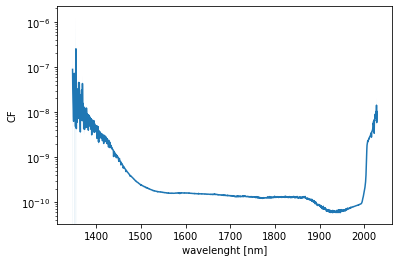

In [26]:
importlib.reload(spec_reader)
importlib.reload(spec_reader.irradiance)
cf_class = spec_reader.irradiance.NIR_CF_Class(reduction_shelf,1200)

book_name = '①refOD1_&_②Thermal_cut_L__x_③Blank_@0mm'
arm_name = "armL"

fig,ax = plt.subplots()
w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

ax.plot(w[300:-300],cf[300:-300],label=arm_name + " - BB")
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
# ax.set_ylim(10**-10,10**-8)
ax.set_yscale("log")
# plt.tick_params(labelsize=15)


In [27]:
book_name = '①refOD1×②Thermal_cut_M__x_③Blank'
arm_name = "armM"

w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name)

ax.plot(w[300:-300],cf[300:-300],label=arm_name + " - BB")
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
ax.set_yscale("log")



Blank doesn't match


In [28]:
book_name = '①absOD1_×_②Thermal_cut_S__x_③Blank'
arm_name = "armS"

w,cf,cf_sterr= cf_class.calc_CF(book_name,arm_name )

ax.plot(w[300:-300],cf[300:-300],label=arm_name+ " - BB")
err_up = cf[300:-300] + cf_sterr[300:-300]
err_down = cf[300:-300] - cf_sterr[300:-300]
ax.fill_between(w[300:-300],err_down ,err_up, alpha=0.2)
ax.set_xlabel("wavelenght [nm]")
ax.set_ylabel("CF")
ax.set_yscale("log")
# plt.tick_params(labelsize=15)

Blank doesn't match


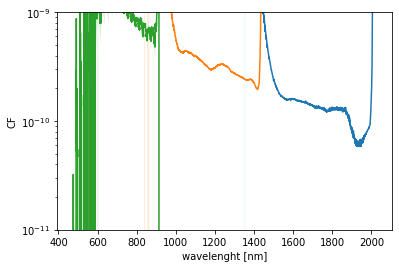

In [29]:
ax.set_ylim(10**-11,10**-9)
display(fig)

In [30]:
file = "./csv/CF_at_LVF_arm_S.csv"
df = pd.read_csv(file)
x = df["wavelength"]
y = df["OD1"]
ax.plot(x, y, label='CF by vis light')

In [31]:
# ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF_calculated")
# ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "WPF_measurement")
# ax.set_ylim(10**-11,10**-8)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# display(fig)

In [32]:
wave_wl_calc = [600.7870565169055, 797.7592330516177]
# cf_wl_calc = [1.3121107691562786e-10, 1.036567737884075e-10]

In [33]:
cf_wl_measure = [3.3556970217447e-10, 2.3772429206896676e-10]
ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF_measurement")
ax.set_ylim(10**-11,10**-8)


(1e-11, 1e-08)

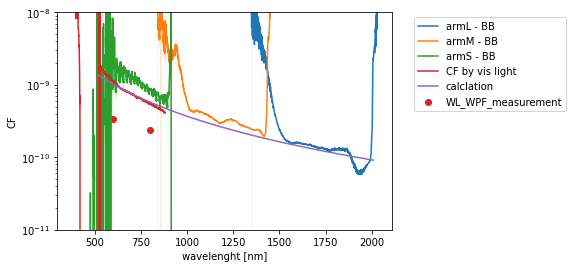

In [34]:
x,y = spec_reader.irradiance.get_cf_from_theory()
ax.plot(x,y,label="calclation")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

display(fig)

In [37]:
file = "./lib/Loading/window_transparent.xlsx"
df = pd.read_excel(file,sheet_name = "Rotation",engine='openpyxl')
x = df["wv_cal"].dropna()
y = df["0deg_cal"].dropna()
waves = np.arange(500,2200,)
y_ip = interpolate.interp1d(x,y,fill_value="extrapolate")(waves)

# fig,ax = plt.subplots()
# ax.plot(x, y, label='CF by vis light')

In [38]:
# fig,ax = plt.subplots()
# ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF_calculated")
# ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "BB_WPF")
# # ax.scatter(wave_wl_calc,cf_wl_calc,label= "WL_WPF_calculated")
# ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF")

# ax.legend(fontsize=13, loc='lower left')
# ax.set_xlim(500,2000)
# ax.set_ylim(10**-11,10**-9)
# ax.set_yscale("log")
# ax.set_xlabel("wavelength [nm]", fontsize=15)
# ax.set_ylabel("CF[(W/$\mathrm{m^2}$/sr/nm)/eps]", fontsize=15)
# plt.tick_params(labelsize=15)
# plt.tight_layout()


# file = "./csv/CF_WPF.csv"
# save_data = np.array([wave_wpf_calc,cf_wpf_calc,cf_wpf_measure,cf_wl_measure+[0,0,0,0]]).T
# print(save_data)
# with open(file,'w',newline='')  as f :
#     csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
#     csv_writer.writerow(np.array(("wavelength","calculation","BB","WL"))) #行一括追加
#     csv_writer.writerows(save_data) #行一括追加    

In [39]:
# fig,ax = plt.subplots()
# for i in range(3):
#     ax.plot(wavelength_calc[i], cf_lvf_calc[i], label=arms[i]+"_LVF")
    
# ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF", color='red')
# # ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "BB_WPF")
# # ax.scatter(wave_wl_calc,cf_wl_measure,label= "WL_WPF")

# ax.set_xlabel("wavelength [nm]", fontsize=15)
# ax.set_ylabel("CF[(W/$\mathrm{m^2}$/sr/nm)/eps]", fontsize=15)
# ax.legend(fontsize=13, loc='upper left', ncol=2)
# ax.set_yscale("log")
# ax.set_ylim(10**-11,10**-8)
# plt.tick_params(labelsize=15)
# plt.tight_layout()

/home/ciber2/python/calibration/fits_reader/shelf.py:100: RuntimeWarning: Mean of empty slice
  img = np.nanmean(imgs,axis=0)
/home/ciber2/python/calibration/fits_reader/shelf.py:104: RuntimeWarning: Mean of empty slice
  bg_img = np.nanmean(bg_imgs,axis=0)


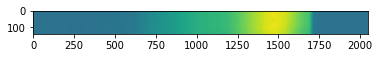

Text(0, 0.5, 'eps')

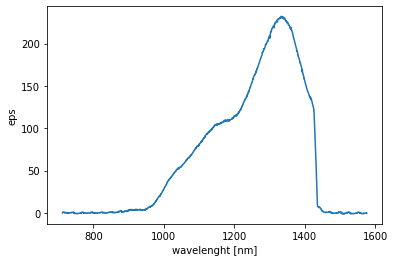

In [40]:
arm_name = "armM"
book_name = '①refOD1×②Thermal_cut_M__x_③Blank'

img =  cf_class.get_lvf_img(book_name,arm_name)
plt.imshow(np.fliplr(img))
plt.show()
w,eps= cf_class.get_wv_vs_eps_at_lvf(book_name,arm_name)
plt.plot(w,eps)
plt.xlabel("wavelenght [nm]")
plt.ylabel("eps")

In [41]:
wvlength_nm = np.arange(500,2200)
wvlength = wvlength_nm * 10**-9

area_t = 5.43 * 10 **-2
pixel_t = 3.76 * 10**-10
det_t = 0.8
topt_t = 0.9*0.9*(0.98**12)*0.9
h_t = 6.6 * 10**-34
c_t = 3 * 10**8

cf_t = (25*h_t*c_t) / (area_t*pixel_t*det_t*topt_t*(wvlength**2)*(10**9))

In [42]:

w,cf= spec_reader.irradiance.get_cf_from_theory()
ax.plot(w,cf,label="estimate")